In [311]:
import rasterio as rio
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [312]:
def euclidian_distance(x1,y1,x2,y2):
    import numpy as np
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [313]:
# set path to the hourly GPS data
GPSpath = '/Users/jukesliu/Documents/TURNER/DATA/GPS/HOURLY_GPS_RECORDS/'
#################################

# Show temporal coverage of GPS records and make sure to filter out times when GPS were buried/destroyed
for GPSfile in os.listdir(GPSpath):
    if GPSfile.endswith('.csv'):
        print(GPSfile)
        GPS_df = pd.read_csv(GPSpath+GPSfile) # read in hourly data file
        GPS_df.datetime = pd.to_datetime(GPS_df.datetime, format='%Y-%m-%d') # convert to datetime
        
        if 'G14_2008' in GPSfile: # remove positions after December 1st for G14_2008
            GPS_df = GPS_df[GPS_df.datetime <= datetime.datetime(2020,12,1)]
        elif 'E5_2108' in GPSfile:
            GPS_df = GPS_df[GPS_df.datetime <= datetime.datetime(2021,11,1)]
            
        # grab date bounds of GPS data
        GPS_t1 = np.nanmin(GPS_df.datetime); GPS_t2 = np.nanmax(GPS_df.datetime)
        
        print(GPS_t1); print(GPS_t2); print(); print()

avg_positions_HOUR_G11_2108.csv
2021-10-02T00:00:00.000000000
2022-03-08T10:00:00.000000000


avg_positions_HOUR_G14_2008.csv
2020-09-05T01:00:00.000000000
2020-12-01T00:00:00.000000000


avg_postiions_HOUR_G15_2106.csv
2021-07-02T00:00:00.000000000
2021-09-02T12:00:00.000000000


avg_positions_HOUR_G12_2008.csv
2020-09-04T23:00:00.000000000
2020-10-30T09:00:00.000000000


avg_positions_HOUR_E5_2108.csv
2021-09-02T00:00:00.000000000
2021-11-01T00:00:00.000000000


avg_positions_HOUR_G9_2110.csv
2021-11-02T00:00:00.000000000
2021-12-24T12:00:00.000000000




In [348]:
autorift_outp = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/output_AutoRIFT/'

# calculate mean GPS vs. vmap speed difference for all velocity maps
ds1s = []; ds2s = []; chipsizes = []; sats = []; filenames = []; avg_speed_diff = []; station_names = [];
all_diffs = []
file_count = 0
# for each velocity map
breaking = False
for output in os.listdir(autorift_outp):
    if output.startswith('velocity') and output.endswith('.tif') and breaking == False:
        [filetype, ds1, ds2, chipsize, sat] = output.split('_') # grab info from filename
        sat = sat.split('.')[0] # s
        d1 = datetime.datetime.strptime(ds1, '%Y%m%d'); d2 = datetime.datetime.strptime(ds2, '%Y%m%d')

        # read in the velocity map
        v_reader = rio.open(autorift_outp+output)
        vx = v_reader.read(1); vy = v_reader.read(2) # grab vx and vy
        v = np.sqrt(vx**2 + vy**2) # calculate vmag from vx and vy
        # raster grid value (UTM coordinates)
        x_vals = np.arange(v_reader.bounds.left, v_reader.bounds.right+1, v_reader.transform[0])
        y_vals = np.arange(v_reader.bounds.bottom, v_reader.bounds.top+1, v_reader.transform[0])
        
        # Identify all GPS records that overlap temporally with d1 to d2
        station_count = 0
        for GPSfile in os.listdir(GPSpath):
            if GPSfile.endswith('.csv'):
                [p1, p2, p3, station, year] = GPSfile.split('_')
                station_name = station+'_'+year[:-4] # grab the station name
                
                GPS_df = pd.read_csv(GPSpath+GPSfile) # read in hourly data file
                GPS_df.datetime = pd.to_datetime(GPS_df.datetime, format='%Y-%m-%d') # convert to datetime

                if 'G14_2008' in GPSfile: # remove positions after December 1st for G14_2008 (buried)
                    GPS_df = GPS_df[GPS_df.datetime <= datetime.datetime(2020,12,1)]
                elif 'E5_2108' in GPSfile: # remove positions after  November 1st for E5_2108 (buried/destroyed)
                    GPS_df = GPS_df[GPS_df.datetime <= datetime.datetime(2021,11,1)]

                # grab date bounds of GPS data
                GPS_t1 = np.nanmin(GPS_df.datetime); GPS_t2 = np.nanmax(GPS_df.datetime)
                
                # grab part of GPS data that overlaps temporally with d1 to d2
                GPS_overlap_df = GPS_df[(GPS_df.datetime >= d1) & (GPS_df.datetime <= d2)]

                if len(GPS_overlap_df) > 0:
                    print(output)
                    print(station_name)
                    
                    # grab the GPS x and y values
                    GPS_x = np.array(GPS_overlap_df.avg_UTMx)
                    GPS_y = np.array(GPS_overlap_df.avg_UTMy)
                    
                    y1 = list(np.where((y_vals >= np.min(GPS_y)))[0])
                    y2 = list(np.where((y_vals <= np.max(GPS_y)))[0])
                    y_pix = np.intersect1d(y1,y2) # grab the overlapping grids
                    x1 = list(np.where((x_vals >= np.min(GPS_x)))[0])
                    x2 = list(np.where((x_vals <= np.max(GPS_x)))[0])
                    x_pix = np.intersect1d(x1,x2) # grab overlapping grids
                    
                    # if there is no intersections, then all GPS data fall within 1 pixel
                    if len(y_pix) == 0:
                        y_pix = [y1[0]-1] # grab the minimum y-pixel bound as a list
                    if len(x_pix) == 0:
                        x_pix = [x1[0]-1] # grab the minimum x-pixel bound as a list
                    
                    pixel_count = 0
                    diffs = []
                    # loop through each pixel
                    for y in y_pix:
                        for x in x_pix:
                            y = int(y); x = int(x) # make sure they are integers
                            vmap_speed_md = v[len(y_vals)-y, x]/365 # grab the speed in m/day
                            
                            # grab GPS data within the pixel bounds
                            GPS_pixel = GPS_overlap_df[(GPS_overlap_df.avg_UTMy >= y_vals[y]) &
                                                       (GPS_overlap_df.avg_UTMy <= y_vals[y+1]) &
                                                       (GPS_overlap_df.avg_UTMx >= x_vals[x]) &
                                                       (GPS_overlap_df.avg_UTMx <= x_vals[x+1])]
                            if len(GPS_pixel) > 0:
                                GPS_pixel = GPS_pixel.reset_index()

                                # grab time elapsed within pixel in fractional days
                                dt_GPS = GPS_pixel.iloc[-1].datetime - GPS_pixel.iloc[0].datetime
                                dt_GPS_days = dt_GPS.days + dt_GPS.seconds/86400 

                               # grab total GPS displacement within pixel
                                GPS_disp = euclidian_distance(GPS_pixel.iloc[0].avg_UTMx, GPS_pixel.iloc[0].avg_UTMy,
                                     GPS_pixel.iloc[-1].avg_UTMx, GPS_pixel.iloc[-1].avg_UTMy)
    #                             print('Displacement from 1st to last position within pixel', GPS_disp)

                                GPS_speed_md = GPS_disp/dt_GPS_days # calculate displacement/time in days

                                # calculate difference vmap and per-pixel GPS speeds
                                speed_diff_md = vmap_speed_md-GPS_speed_md
                                print('Speed GPS vs. vmap [m/d]:',GPS_speed_md, vmap_speed_md)

                                diffs.append(speed_diff_md)
                                pixel_count += 1
                    print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
                    ds1s.append(ds1); ds2s.append(ds2); 
                    chipsizes.append(int(chipsize[:-1])); sats.append(sat)
                    avg_speed_diff.append(np.nanmean(diffs))
                    filenames.append(output)
                    station_names.append(station_name)
        
                    print(); print(); print()
                            
        # get ready for next iteration
        del v, vx, vy
        
        file_count += 1
        
print(file_count, 'files found.')
speed_diff_df = pd.DataFrame(list(zip(filenames, avg_speed_diff, station_names, ds1s, ds2s, chipsizes, sats)),
                            columns=['filename','mean_speed_diff','GPS_station','ds1','ds2','min_chip_size','sat'])

velocity_20210815_20210830_300m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 0.10312063382313601 0.7214623020119864
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.6183416681888504



velocity_20210701_20210704_200m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.66543584493504 3.6592014260488015
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -2.006234418886238



velocity_20220130_20220219_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.07179061933330208 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20200924_20201017_300m_S2.tif
G14_2008
Speed GPS vs. vmap [m/d]: 9.646103022363755 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20200924_20201017_300m_S2.tif
G12_2008
Speed GPS vs. vmap [m/d]: 10.732499637491376 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20210719_20210729_300m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 4.629397411141037 5.297889019691781
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.6684916085507444



velocity_20220115_20220119_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.17290803672884364 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20210830_20210907_160m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 0.026807143497960432 1.3351434577001284
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.308336314202168



velocity_20210830_20210907_160m_S2.tif
E5_2108
Speed GPS vs. vmap [m/d]: 0.44703999749249956 0.42835375642123286
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -0.018686241071266707





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20210907_20210919_200m_S2.tif
E5_2108
Speed GPS vs. vmap [m/d]: 0.2939241581826293 0.5009214636397689
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.20699730545713957



velocity_20210704_20210716_100m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.013417581686613 6.425183941566781
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.4117663598801675



velocity_20210716_20210719_160m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 6.383473979944064 4.794213532748287
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -1.5892604471957767



velocity_20200914_20200924_200m_S2.tif
G14_2008
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20200914_20200924_200m_S2.tif
G12_2008
Speed GPS vs. vmap [m/d]: 14.377132131410102 16.73285397046233
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 2.3557218390522277





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220301_20220306_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.43936468227297415 2.184149253531678
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.7447845712587038



velocity_20220117_20220202_100m_LS.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.018449156517461367 2.3887859187714042
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 2.370336762253943



velocity_20210922_20211004_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.1451075267836565 0.7431006862692637
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.5979931594856073



velocity_20200904_20200914_300m_S2.tif
G14_2008
Speed GPS vs. vmap [m/d]: 11.043346257042419 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20200904_20200914_300m_S2.tif
G12_2008
Speed GPS vs. vmap [m/d]: 14.354502289007762 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220306_20220320_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.8982846997336653 1.432098472281678
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.5338137725480128



velocity_20210803_20210815_100m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 3.102606478629516 4.571499424764554
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.4688929461350382



velocity_20220223_20220301_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.22898801298011603 1.6513372551904966
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.4223492422103805



velocity_20210729_20210803_100m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.277835358286487 3.8329369113869864
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -1.4448984468995008



velocity_20210704_20210716_160m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.186402054074223 6.694341957405822
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.5079399033315992



velocity_20210716_20210719_100m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.279041954748399 5.207551971853596
AVERAGE SPEED DIFFERENCE FOR 

<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20210701_20210704_300m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.66543584493504 3.727507625214041
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -1.9379282197209986



velocity_20200924_20201017_200m_S2.tif
G14_2008
Speed GPS vs. vmap [m/d]: 9.646103022363755 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20200924_20201017_200m_S2.tif
G12_2008
Speed GPS vs. vmap [m/d]: 9.588364316493195 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20210922_20211004_160m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.1451075267836565 0.7742744341288528
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.6291669073451963





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20210729_20210803_160m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 4.799613865244685 3.9027484214469177
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -0.896865443797767



velocity_20210803_20210815_160m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 3.627849517278802 4.626355482127568
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.9985059648487664



velocity_20210907_20210919_300m_S2.tif
E5_2108
Speed GPS vs. vmap [m/d]: 0.2939241581826293 0.5729166527316994
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.27899249454907016



velocity_20210719_20210729_200m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 4.629397411141037 5.23428169145976
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.6048842803187231



velocity_20220219_20220223_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.03569592438000182 2.260568279109589
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 2.224872354729587



velocity_20220120_20220130_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.10840562725396004 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220201_20220204_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.684572199505289 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20201010_20201120_100m_LS.tif
G14_2008
Speed GPS vs. vmap [m/d]: 14.168604373280274 nan
Speed GPS vs. vmap [m/d]: 13.458675028979645 nan
Speed GPS vs. vmap [m/d]: 14.586930833176526 nan
Speed GPS vs. vmap [m/d]: 11.955110097778276 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20201010_20201120_100m_LS.tif
G12_2008
Speed GPS vs. vmap [m/d]: 11.595850965429747 13.258092091181506
Speed GPS vs. vmap [m/d]: 13.703776056077668 13.960981645976027
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.9597233578250588





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220125_20220129_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.11959466410764999 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20220117_20220120_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.11062277095278468 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20200914_20200924_300m_S2.tif
G14_2008
Speed GPS vs. vmap [m/d]: 12.341957236624886 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20200914_20200924_300m_S2.tif
G12_2008
Speed GPS vs. vmap [m/d]: 14.377132131410102 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20200904_20200914_200m_S2.tif
G14_2008
Speed GPS vs. vmap [m/d]: 11.043346257042419 11.425337114726027
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.38199085768360774



velocity_20200904_20200914_200m_S2.tif
G12_2008
Speed GPS vs. vmap [m/d]: 14.354502289007762 13.038825717037671
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -1.3156765719700907



velocity_20210830_20210907_100m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 0.026807143497960432 1.3740064647099743
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.347199321212014



velocity_20210830_20210907_100m_S2.tif
E5_2108
Speed GPS vs. vmap [m/d]: 0.44703999749249956 0.3601384411119435
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -0.08690155638055608



velocity_20200914_20200924_160m_S2.tif
G14_2008
Speed GPS vs. vmap [m/d]: 12.341957236624886 12.320984053938357
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -0.020973182686528702



velocity_20200914_20200924_160m_S2.tif
G12_2008
Speed GPS vs. vmap [m/d]: 14.146230974078724 13.43982502140411
AVERAGE SPEED DI

<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20210716_20210719_200m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.279041954748399 5.182488093964041
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -0.09655386078435768



velocity_20210815_20210830_100m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 0.10312063382313601 0.769001247458262
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.6658806136351261



velocity_20210719_20210729_100m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 4.629397411141037 5.078125
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.44872758885896324



velocity_20220219_20220223_200m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.03569592438000182 1.4780022608090753
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.4423063364290734



velocity_20220120_20220130_200m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.10840562725396004 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220208_20220211_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.6709729098439273 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20200924_20201017_100m_S2.tif
G14_2008
Speed GPS vs. vmap [m/d]: 7.056772745088877 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20200924_20201017_100m_S2.tif
G12_2008
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220112_20220115_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.4707907414825809 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220117_20220120_200m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.11062277095278468 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20201010_20201120_200m_LS.tif
G14_2008
Speed GPS vs. vmap [m/d]: 13.216702090018556 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20201010_20201120_200m_LS.tif
G12_2008
Speed GPS vs. vmap [m/d]: 13.703776056077668 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20210701_20210704_160m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.66543584493504 3.336993324593322
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -2.3284425203417176





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20210704_20210716_300m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.186402054074223 6.519473057577055
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.3330710035028321



velocity_20220221_20220224_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.25327798022932296 3.8685683995077054
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 3.6152904192783826



velocity_20210803_20210815_300m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 3.102606478629516 5.003135702054794
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.900529223425278



velocity_20210907_20210919_160m_S2.tif
E5_2108
Speed GPS vs. vmap [m/d]: 0.2939241581826293 0.5860821449593322
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.2921579867767029



velocity_20220306_20220320_300m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.8982846997336653 1.4774778601241438
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.5791931603904785



velocity_20220223_20220301_300m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.22898801298011603 1.8912509029858733
AVERAGE SPEED DIFFERENCE FO

<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220117_20220202_300m_LS.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.018449156517461367 2.151276554473459
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 2.1328273979559977



velocity_20220228_20220303_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 1.0735280635504738 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20200904_20200914_100m_S2.tif
G14_2008
Speed GPS vs. vmap [m/d]: 11.161360777713856 11.242814907962329
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.08145413024847237



velocity_20200904_20200914_100m_S2.tif
G12_2008
Speed GPS vs. vmap [m/d]: 15.639703363682804 13.112504013270549
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -2.527199350412255



velocity_20210922_20211004_300m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.1451075267836565 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220130_20220219_200m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.07179061933330208 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20210701_20210704_100m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.66543584493504 3.441049403360445
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -2.2243864415745946



velocity_20210716_20210719_300m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 6.383473979944064 5.623311750856164
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -0.7601622290879



velocity_20220218_20220221_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.3021253649323885 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20210907_20210919_100m_S2.tif
E5_2108
Speed GPS vs. vmap [m/d]: 0.2939241581826293 0.5766038868525257
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.28267972866989644



velocity_20220219_20220223_300m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.03569592438000182 1.7491103916952055
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.7134144673152036



velocity_20220120_20220130_300m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.10840562725396004 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220211_20220214_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.6330827824906752 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20200904_20200914_160m_S2.tif
G14_2008
Speed GPS vs. vmap [m/d]: 11.968645890107146 11.327898919092465
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -0.6407469710146803



velocity_20200904_20200914_160m_S2.tif
G12_2008
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220119_20220122_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.3814180009725234 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20201010_20201120_300m_LS.tif
G14_2008
Speed GPS vs. vmap [m/d]: 14.214027496085864 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20201010_20201120_300m_LS.tif
G12_2008
Speed GPS vs. vmap [m/d]: 13.196756247772518 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220117_20220120_300m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.11062277095278468 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20200914_20200924_100m_S2.tif
G14_2008
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20200914_20200924_100m_S2.tif
G12_2008
Speed GPS vs. vmap [m/d]: 14.217208179275932 14.137059877996576
Speed GPS vs. vmap [m/d]: 15.30126056138953 14.157475385273973
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -0.6119667386974568





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220122_20220125_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.24634112734933908 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20210815_20210830_160m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 0.10312063382313601 0.7950176082245292
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.6918969744013932





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20210704_20210716_200m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.013417581686613 6.592657721532534
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.579240139845921



velocity_20210719_20210729_160m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 4.629397411141037 5.129666095890411
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.5002686847493738



velocity_20220129_20220201_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.6171089225108402 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20210803_20210815_200m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 3.2109014612654763 4.81538520708476
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.6044837458192838



velocity_20220306_20220320_200m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.8982846997336653 1.6053204262093321
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.7070357264756668





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220214_20220218_100m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.34956131056833245 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20210729_20210803_200m_S2.tif
G15_2106
Speed GPS vs. vmap [m/d]: 5.277835358286487 3.9598820098458902
AVERAGE SPEED DIFFERENCE FOR THE VMAP: -1.317953348440597



velocity_20220223_20220301_200m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.22898801298011603 1.282403397233519
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.0534153842534029



velocity_20210830_20210907_300m_S2.tif
G15_2106


<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


Speed GPS vs. vmap [m/d]: 0.026807143497960432 1.69921875
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.6724116065020396



velocity_20210830_20210907_300m_S2.tif
E5_2108
Speed GPS vs. vmap [m/d]: 0.44703999749249956 0.5070607224555864
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.06002072496308686



velocity_20210922_20211004_200m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.1451075267836565 0.9937719893782107
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 0.8486644625945542



velocity_20200924_20201017_160m_S2.tif
G14_2008
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20200924_20201017_160m_S2.tif
G12_2008
Speed GPS vs. vmap [m/d]: 11.695361032650483 nan
Speed GPS vs. vmap [m/d]: 9.973877346857153 nan
AVERAGE SPEED DIFFERENCE FOR THE VMAP: nan



velocity_20220301_20220306_200m_S2.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.43936468227297415 2.320299289651113
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 1.880934607378139





<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:98: RuntimeWarning: Mean of empty slice
  print('AVERAGE SPEED DIFFERENCE FOR THE VMAP:',np.nanmean(diffs))
<ipython-input-348-06b05d4a15df>:101: RuntimeWarning: Mean of empty slice
  avg_speed_diff.append(np.nanmean(diffs))


velocity_20220117_20220202_200m_LS.tif
G11_2108
Speed GPS vs. vmap [m/d]: 0.018449156517461367 2.368808192422945
AVERAGE SPEED DIFFERENCE FOR THE VMAP: 2.350359035905484



813 files found.


In [349]:
speed_diff_df = speed_diff_df.dropna()

In [350]:
all_diffs = speed_diff_df.mean_speed_diff
print(np.nanmean(all_diffs)) # mean GPS - velocity map difference
print(np.nanstd(all_diffs)) # standard deviation in speed differences

0.47869552570993956
1.2698804115855362


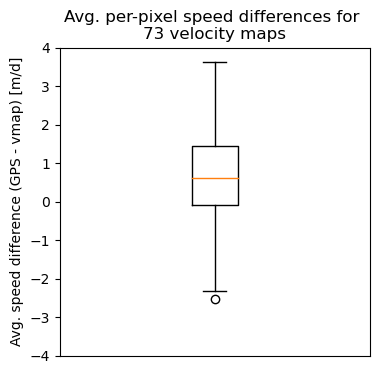

In [351]:
plt.figure(figsize=(4,4))
plt.boxplot(all_diffs)
plt.ylim(-4,4)
plt.title('Avg. per-pixel speed differences for \n'+str(len(all_diffs_nonans))+' velocity maps')
plt.xticks([])
plt.ylabel('Avg. speed difference (GPS - vmap) [m/d]')
plt.show()

In [352]:
print('filename                                      GPS stations            respective speed errors')
for unique_vmap in list(set(speed_diff_df.filename)):
    vmap_df = speed_diff_df[speed_diff_df.filename == unique_vmap]
    if len(vmap_df.filename) > 1:
        print(vmap_df.filename.iloc[0], list(vmap_df.GPS_station), list(vmap_df.mean_speed_diff))

filename                                      GPS stations            respective speed errors
velocity_20200914_20200924_160m_S2.tif ['G14_2008', 'G12_2008'] [-0.020973182686528702, -0.7064059526746149]
velocity_20210830_20210907_160m_S2.tif ['G15_2106', 'E5_2108'] [1.308336314202168, -0.018686241071266707]
velocity_20200904_20200914_100m_S2.tif ['G14_2008', 'G12_2008'] [0.08145413024847237, -2.527199350412255]
velocity_20200904_20200914_200m_S2.tif ['G14_2008', 'G12_2008'] [0.38199085768360774, -1.3156765719700907]
velocity_20210830_20210907_300m_S2.tif ['G15_2106', 'E5_2108'] [1.6724116065020396, 0.06002072496308686]
velocity_20210830_20210907_100m_S2.tif ['G15_2106', 'E5_2108'] [1.347199321212014, -0.08690155638055608]
velocity_20210830_20210907_200m_S2.tif ['G15_2106', 'E5_2108'] [1.441288191743906, -0.14195211104798972]


In [353]:
len(speed_diff_df.filename)

69

In [354]:
speed_diff_df[speed_diff_df.GPS_station == 'G12_2008']

,filename,mean_speed_diff,GPS_station,ds1,ds2,min_chip_size,sat
13,velocity_20200914_20200924_200m_S2.tif,2.355722,G12_2008,20200914,20200924,200,S2
39,velocity_20201010_20201120_100m_LS.tif,0.959723,G12_2008,20201010,20201120,100,LS
45,velocity_20200904_20200914_200m_S2.tif,-1.315677,G12_2008,20200904,20200914,200,S2
49,velocity_20200914_20200924_160m_S2.tif,-0.706406,G12_2008,20200914,20200924,160,S2
79,velocity_20200904_20200914_100m_S2.tif,-2.527199,G12_2008,20200904,20200914,100,S2
96,velocity_20200914_20200924_100m_S2.tif,-0.611967,G12_2008,20200914,20200924,100,S2


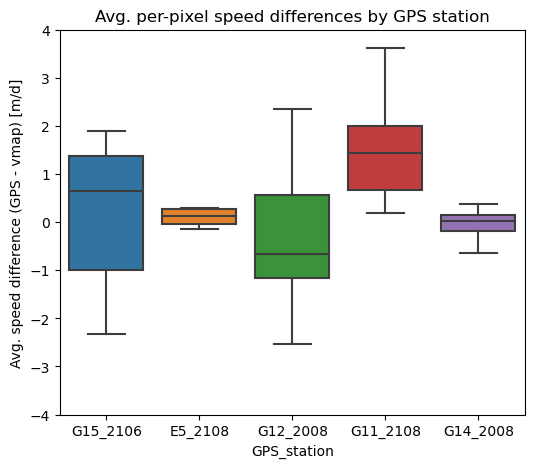

In [355]:
plt.figure(figsize=(6,5))
sns.boxplot(data=speed_diff_df, x="GPS_station", y="mean_speed_diff")
plt.ylim(-4,4)
plt.ylabel('Avg. speed difference (GPS - vmap) [m/d]')
plt.title('Avg. per-pixel speed differences by GPS station')
plt.show()

## Compare with stable surface errors

In [373]:
# load stable surface errors
sse_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/speed_timeseries_thru_pts_S1_included_adjustedssm.csv')
sse_df = sse_df.drop(columns=['Unnamed: 0.1','Unnamed: 0'])

# sse_df.ds1 = pd.to_datetime(sse_df.ds1); sse_df.ds2 = pd.to_datetime(sse_df.ds2);
sse_df

,ds1,ds2,min_chip_size,sat,err_vx,err_vy,err_v,s1,s5,s9,s15,s18,s24,s28,s22,s17
0,20190327,20190401,160,S2,0.060632,0.514467,0.518027,645.234900,594.87720,653.250550,1633.046800,2232.888200,2710.370800,1506.488900,573.610800,707.003540
1,20150515,20150522,300,LS,0.003403,0.002183,0.004043,2.860045,5.66182,6.952041,7.474257,12.785855,27.424217,15.302672,3.499182,1.520792
2,20220519,20220522,200,S2,0.270222,0.593957,0.652537,932.092200,544.37550,697.192600,NaN,NaN,NaN,NaN,NaN,NaN
3,20200402,20200405,300,S2,0.714413,0.294911,0.772889,1720.836500,1881.64710,1008.269170,4278.400000,3244.549600,3242.822500,2146.830800,2947.166500,3303.494100
4,20180516,20180531,200,S2,0.198815,0.067081,0.209827,240.284440,224.83786,323.378330,508.883000,1163.835100,2492.757800,1184.115500,808.307100,310.958340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,20191128,20191210,120,S1,NaN,NaN,0.279730,33.000000,125.00000,NaN,173.000000,385.000000,NaN,851.000000,29.000000,133.000000
929,20170717,20170729,120,S1,NaN,NaN,0.157873,113.000000,121.00000,NaN,1039.000000,NaN,NaN,840.000000,NaN,NaN
930,20220329,20220410,120,S1,NaN,NaN,0.285337,474.000000,113.00000,NaN,NaN,NaN,NaN,1105.000000,171.000000,73.000000
931,20200725,20200806,120,S1,NaN,NaN,0.169863,NaN,NaN,NaN,NaN,NaN,NaN,1054.000000,NaN,NaN


In [374]:
# join sse_df with speed_diff_df
speed_diff_df.ds1 = speed_diff_df.ds1.astype('int64'); speed_diff_df.ds2 = speed_diff_df.ds2.astype('int64')
compare_df = pd.merge(sse_df, speed_diff_df, on=['ds1','ds2','min_chip_size', 'sat'])
compare_df

,ds1,ds2,min_chip_size,sat,err_vx,err_vy,err_v,s1,s5,s9,s15,s18,s24,s28,s22,s17,filename,mean_speed_diff,GPS_station
0,20210815,20210830,300,S2,0.057026,0.254527,0.260837,1547.68600,274.17212,271.65613,287.07617,304.38046,1968.8221,1102.6107,336.32860,302.30750,velocity_20210815_20210830_300m_S2.tif,0.618342,G15_2106
1,20210701,20210704,200,S2,0.211182,0.237273,0.317642,5803.25500,4059.69210,3011.21630,1115.79970,3360.59860,2152.2950,1280.6306,942.50260,825.36743,velocity_20210701_20210704_200m_S2.tif,-2.006234,G15_2106
2,20210719,20210729,300,S2,0.042338,0.035372,0.055170,5436.39750,3631.06800,3471.31100,1479.00180,1130.96000,NaN,1336.4431,NaN,1157.45340,velocity_20210719_20210729_300m_S2.tif,0.668492,G15_2106
3,20210830,20210907,160,S2,0.086354,0.096800,0.129720,1444.54930,221.79951,327.15387,556.10040,1041.43040,2377.9900,1558.0371,420.66590,477.68990,velocity_20210830_20210907_160m_S2.tif,1.308336,G15_2106
4,20210830,20210907,160,S2,0.086354,0.096800,0.129720,1444.54930,221.79951,327.15387,556.10040,1041.43040,2377.9900,1558.0371,420.66590,477.68990,velocity_20210830_20210907_160m_S2.tif,-0.018686,E5_2108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20210830,20210907,300,S2,0.081981,0.094360,0.124999,1420.44240,270.99222,146.96617,556.10040,1063.37850,2409.8867,1289.9972,456.25000,415.68310,velocity_20210830_20210907_300m_S2.tif,1.672412,G15_2106
65,20210830,20210907,300,S2,0.081981,0.094360,0.124999,1420.44240,270.99222,146.96617,556.10040,1063.37850,2409.8867,1289.9972,456.25000,415.68310,velocity_20210830_20210907_300m_S2.tif,0.060021,E5_2108
66,20210922,20211004,200,S2,0.066098,0.150855,0.164700,918.18787,227.43085,284.28360,356.22345,563.30890,NaN,1416.7544,326.29227,314.67838,velocity_20210922_20211004_200m_S2.tif,0.848664,G11_2108
67,20220301,20220306,200,S2,0.381049,0.798725,0.884963,696.15515,862.81330,818.79080,832.73440,970.53720,1942.8163,NaN,NaN,857.21594,velocity_20220301_20220306_200m_S2.tif,1.880935,G11_2108


In [391]:
np.nanmean(sse_df.err_v)

0.38872628083455857

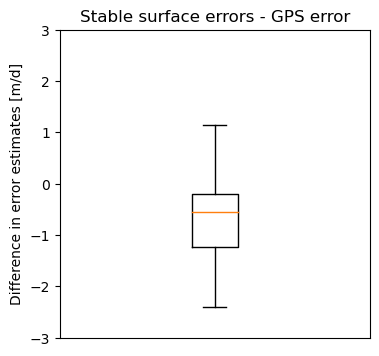

-0.7473032367080097
0.7023152889002258


In [396]:
sse_v_GPS_errors = np.array(compare_df.err_v) - np.array(np.abs(compare_df.mean_speed_diff))

plt.figure(figsize=(4,4))
plt.boxplot(sse_v_GPS_errors)
# plt.boxplot(sse_df.dropna().err_v)
plt.title('Stable surface errors - GPS error')
plt.ylabel('Difference in error estimates [m/d]')
plt.ylim(-3,3)
plt.xticks([])
plt.show()
print(np.nanmean(sse_v_GPS_errors))
print(np.nanstd(sse_v_GPS_errors))

In [322]:
# for output in os.listdir(autorift_outp):
#     if output.startswith('velocity') and output.endswith('.tif') and breaking == False:
#         [filetype, ds1, ds2, chipsize, sat] = output.split('_') # grab info from filename
#         sat = sat.split('.')[0] # s
#         d1 = datetime.datetime.strptime(ds1, '%Y%m%d'); d2 = datetime.datetime.strptime(ds2, '%Y%m%d')
        
#         if d1 >= datetime.datetime(2020, 9, 4) and d2 <= datetime.datetime(2020, 9, 14) and chipsize == '350m':
#             print(output)
            
#             # read in the velocity map
#             v_reader = rio.open(autorift_outp+output)
#             vx = v_reader.read(1); vy = v_reader.read(2) # grab vx and vy
#             v = np.sqrt(vx**2 + vy**2) # calculate vmag from vx and vy
#             # raster grid value (UTM coordinates)
            
#             plt.imshow(v)
#             plt.colorbar()
#             plt.show()